## Part 2 Network Analysis in Computational Social Science

In [1]:
import json
import networkx as nx
from networkx.readwrite import json_graph
from collections import defaultdict
import numpy as np
import random
import netwulf as nw
import matplotlib.pyplot as plt

### Exercise 1: Mixing Patterns and Assortativity

### Part 1: Assortativity Coefficient

1. Calculate the Assortativity Coefficient for the network based on the country of each node. Implement the calculation using the formula provided during the lecture, also available in this paper (equation 2, here for directed networks). Do not use the NetworkX implementation.

In [2]:
with open("network.json", "r") as f:
    graph_data = json.load(f)
Graph = json_graph.node_link_graph(graph_data)
Graph.number_of_edges(), Graph.number_of_nodes()

(59432, 15101)

In [3]:
e = nx.attribute_mixing_matrix(Graph,"country")
eii = 0
ai_bi = 0
for i in range(e.shape[0]):
    eii += e[i][i]
    ai = sum(e[i])
    bi = sum(e[:,i])
    ai_bi += ai*bi

r = (eii-ai_bi)/(1-ai_bi)
r

0.34125245979211066

check with nx function if it is correct

In [4]:
nx.attribute_assortativity_coefficient(Graph, "country")

0.34125245979211094

### Part 2: Configuration model
In the following, we are going to assess the significance of the assortativity by comparing the network's assortativity coefficient against that of random networks generated through the configuration model.  

2. *Implement the configuration model* using the _double edge swap_ algorithm to generate random networks. Ensure each node retains its original degree but with altered connections. Create a function that does that by following these steps:
- **a.** Create an exact copy of your original network.
- **b.** Select two edges, $e_{1} = (u,v)$ and $e_{2} = (x,y)$, ensuring *u != y* and *v != x*.
- **c.** Flip the direction of $e_{1}$ to $e_{1} = (v,u)$ 50% of the time. This ensure that your final results is not biased, in case your edges were sorted (they usually are). 
- **d.** Ensure that new edges $e_{1}' = (e_{1}[0],e_{2}[1])$ and $e_{2}' = (e_{2}[0],e_{1}[1])$ do not already exist in the network.
- **e.** Remove edges $e_{1}$ and $e_{2}$ and add edges $e_{1}'$ and $e_{2}'$.
- **f.** Repeat steps **b** to **e** until you have performed _E*10_ swaps, where E is the total number of edges.

In [6]:
def double_edge_swap(G):
    copy = G.copy()
    nswaps = 10 * copy.number_of_edges()  # Perform E*10 swaps
    n = 0
    
    while n < nswaps:
        edges = list(copy.edges())
        
        # Select two distinct edges randomly
        e1, e2 = random.sample(edges, 2)
        u, v = e1
        x, y = e2
        
        # Flip the direction of e1 50% of the time
        if random.random() < 0.5:
            u, v = v, u
        
        # Check if u != y and v != x
        if u == y or v == x:
            continue
        
        # Check if new edges do not already exist
        if copy.has_edge(u, y) or copy.has_edge(x, v):
            continue
        
        # Ensure the original edges are still present before removal
        if not copy.has_edge(e1[0], e1[1]) or not copy.has_edge(e2[0], e2[1]):
            continue
        
        # Remove the original edges and add the new edges
        copy.remove_edge(e1[0], e1[1])
        copy.remove_edge(e2[0], e2[1])
        copy.add_edge(u, y)
        copy.add_edge(x, v)
        
        n += 1
    
    return copy

3. *Double check that your algorithm works well*, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.

In [ ]:
randomized_G = double_edge_swap(Graph)

# Verify degrees are preserved
original_degrees = dict(Graph.degree())
randomized_degrees = dict(randomized_G.degree())
print("Degrees match:", original_degrees == randomized_degrees)

### Part 3: Analyzing Assortativity in Random Networks
4. *Generate and analyze at least 100 random networks* using the configuration model. For each, calculate the assortativity with respect to the country and plot the distribution of these values. Compare the results with the assortativity of your original network to determine if connections within the same country are significantly higher than chance.

### Exercise 3: Zachary's karate club__: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable//auto_examples/graph/plot_karate_club.html) 

1. Visualize the graph. Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.

In [53]:
Graph = nx.karate_club_graph()
list(Graph.nodes(data=True))[:3]


[(0, {'club': 'Mr. Hi'}), (1, {'club': 'Mr. Hi'}), (2, {'club': 'Mr. Hi'})]

In [3]:
for k,v in Graph.nodes(data=True):
    v["group"] = v["club"]
nw.visualize(Graph)

c:\Users\mia\miniconda3\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


(None, None)

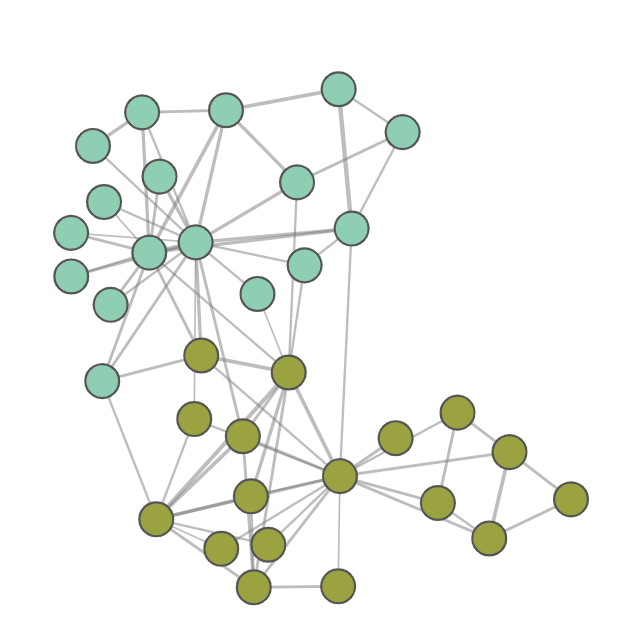

2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

In [3]:
def modularity(graph: nx.graph, partitioning: str):
    """
    Input:
    graph = nx:
    partitioning = string, desctiping the 
    """
    L = graph.number_of_edges()
    club = nx.get_node_attributes(Graph, partitioning)
    M = 0
    for value in set(club.values()):
        club_nodes = []
        for i in range(len(club)):
            if club[i] == value:
                club_nodes.append(i)
        sub_graph = graph.subgraph(club_nodes)
        Lc = sub_graph.number_of_edges()
        kc = sum(value for _, value in list(sub_graph.degree()))
        M += Lc/L-(kc/(2*L))**2
    return M

3. Explain in your own words the concept of _modularity_. 

Modularity is a quantity that can be used to compare communities

4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.

In [17]:
m_real = modularity(Graph,"club")
m_real

0.48931623931623935

5. Create $1000$ randomized version of the Karate Club network using the _double edge swap_ algorithm you wrote in the exercise above 5. For each of them, compute the modularity of the "club" split and store it in a list.

In [7]:
mod_list = []

for i in range(1000):
    G = double_edge_swap(Graph)
    m = modularity(G,"club")
    mod_list.append(m)
mod_list[0]

0.398586456278764

6. Compute the average and standard deviation of the modularity for the random network.

In [8]:
np.mean(mod_list), np.std(mod_list)

(np.float64(0.364620644312952), np.float64(0.025479504038419698))

7. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 

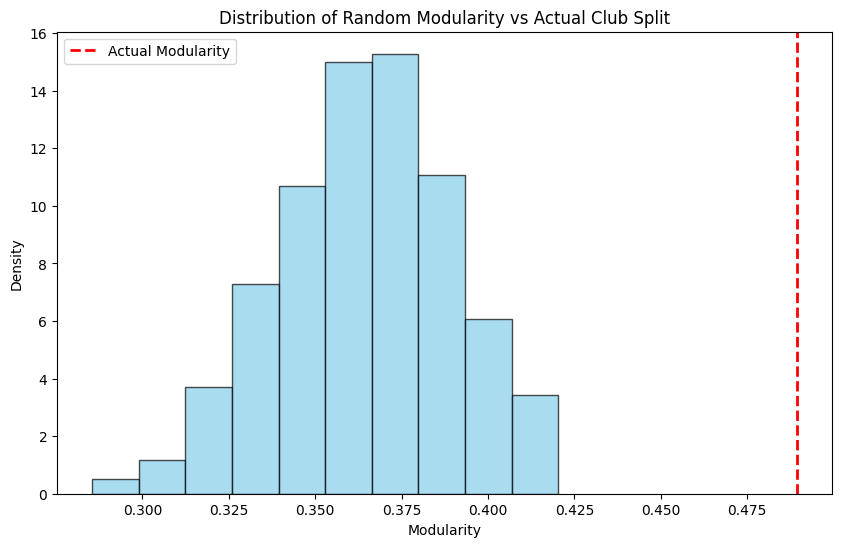

In [56]:
plt.figure(figsize=(10, 6))
plt.hist(mod_list, bins=10, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(m_real, color='red', linestyle='--', linewidth=2, label='Actual Modularity')
plt.xlabel('Modularity')
plt.ylabel('Density')
plt.title('Distribution of Random Modularity vs Actual Club Split')
plt.legend()
plt.show()

8. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?

Club split seems to be a good partitoning, as the orginial is far higher than the randoms. I think we can use the randomization experiment, to say how often would this split randomly occur. That is also why we find the mean and standard deviation, too see how much of an outlier our result is <br>
We preserved the nodes degree, because we want to be able to compare the networks.

9.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

In [55]:
from community import community_louvain
partition = community_louvain.best_partition(Graph)
louvain_communities = {}
for node, comm_id in partition.items():
    if comm_id not in louvain_communities:
        louvain_communities[comm_id] = []
    louvain_communities[comm_id].append(node)
A = len(louvain_communities)
community_louvain.modularity(partition,Graph)

0.4345214669889994

The modulartity is lower than the one from orginal club split, but still higher than the random ones. This implies that the best split is the orginal

10.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [ ]:
D = np.zeros((A, 2), dtype=int)
club_split = [0 if Graph.nodes[i]['club'] == 'Mr. Hi' else 1 for i in Graph.nodes]

for louvain_id in louvain_communities:
    for node in louvain_communities[louvain_id]:
        club_id = club_split[node]
        D[louvain_id, club_id] += 1
D

array([[4, 6],
       [5, 3],
       [1, 3],
       [7, 5]])

The Louvain algorithm found 4 communities instead of the original 2. The confusion matrix can be explained as the first column is the club "Mr.Hi" while the secound is the "Officer". An ideal confusion matrix whould have been $[[17,0],[0,17]]$ <br>
Instead we have a mix, where no partitioning really correspond to the club split